In [1]:
# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../../../Data/BNB-USD.csv', usecols=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'])
df.dropna()
df.reset_index(drop=True)

,Date,Close
0,2017-11-09,1.990770
1,2017-11-10,1.796840
2,2017-11-11,1.670470
3,2017-11-12,1.519690
4,2017-11-13,1.686620
...,...,...
2039,2023-06-10,239.089081
2040,2023-06-11,235.438797
2041,2023-06-12,231.051437
2042,2023-06-13,243.890533


In [3]:
# Rename to fit to prophet model
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
# Train test val split in 8:1:1 set
test_size = int(len(df)*0.1)
val_size = int(len(df)*0.1)
train_size = int(len(df)-test_size-val_size)

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
# Fitting
prophet = Prophet()
model = prophet.fit(train_data)

06:53:09 - cmdstanpy - INFO - Chain [1] start processing
06:53:10 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
y_test_pred= model.predict(test_data)
y_val_pred = model.predict(val_data)

In [6]:
# RMSE
rmse = mean_squared_error(test_data['y'], y_test_pred['yhat'], squared=False)
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))

The root mean squared error (RMSE) on test set: 190.275


In [7]:
#MAPE
mape = mean_absolute_percentage_error(test_data['y'], y_test_pred['yhat'])
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The mean absolute percentage error (MAPE) on test set: 0.686


In [8]:
# EVS 
evs = explained_variance_score(test_data['y'], y_test_pred['yhat'])
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))

The explained variance score (EVS) on test set: 0.200


In [9]:
import datetime

last_day = df['ds'].iloc[-1]
next_days = np.array([])

for i in range(0, 30):
    last_day = last_day+datetime.timedelta(days=1)
    next_days = np.append(next_days, last_day)

X_30 = pd.DataFrame([])
X_30['ds'] = next_days 

y_30_pred = model.predict(X_30)

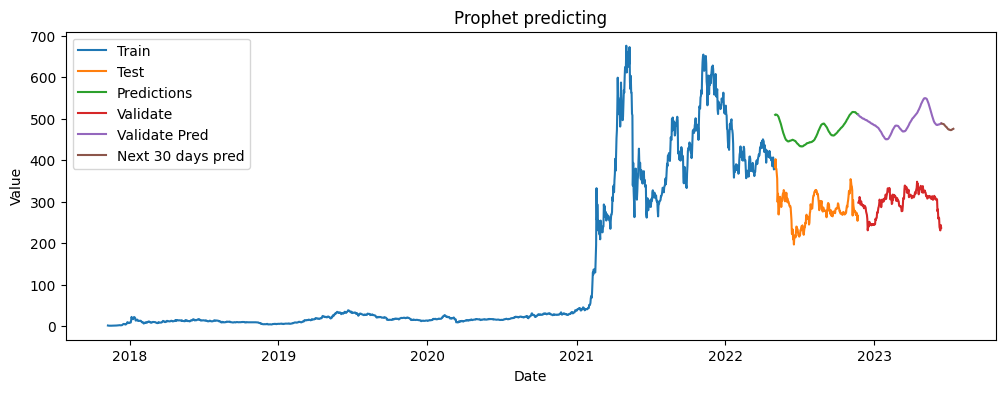

In [10]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 4))
# Biểu đồ tập train
plt.plot(train_data['ds'], train_data['y'], label='Train')

# Biểu đồ tập test
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(y_test_pred['ds'], y_test_pred['yhat'], label='Predictions')

# Biểu đồ tập validate
plt.plot(val_data['ds'], val_data['y'], label='Validate')
plt.plot(y_val_pred['ds'], y_val_pred['yhat'],
         label='Validate Pred')

# Predicting next 30 days 
plt.plot(X_30['ds'], y_30_pred['yhat'], label='Next 30 days pred')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet predicting')
plt.legend(loc='upper left')
plt.show()


In [11]:
# Identify anomalies in the data based on the prediction residuals
df_pred = pd.DataFrame([])
df_pred = df_pred.reset_index(drop=True)
start_index = test_data.index.start
df_pred.index += start_index
df_pred = df.loc[start_index:]
df_pred['yhat'] = np.union1d(y_test_pred['yhat'], y_val_pred['yhat'])
df_pred['residual']  = df_pred['y'] - df_pred['yhat']
df_pred['anomaly'] = (df_pred['residual'].abs() > 3 * df_pred['residual'].std()).astype(int)

C:\Users\AspireA514\AppData\Local\Temp\ipykernel_30660\2331648115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['yhat'] = np.union1d(y_test_pred['yhat'], y_val_pred['yhat'])
C:\Users\AspireA514\AppData\Local\Temp\ipykernel_30660\2331648115.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['residual']  = df_pred['y'] - df_pred['yhat']
C:\Users\AspireA514\AppData\Local\Temp\ipykernel_30660\2331648115.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

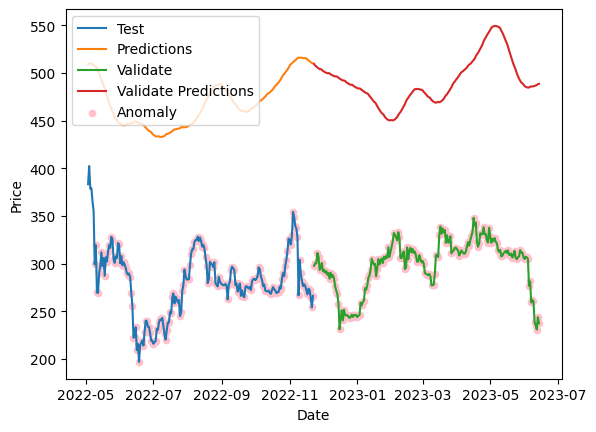

In [12]:
# Vẽ biểu đồ
fig, ax = plt.subplots()
# Biểu đồ tập train

# Biểu đồ tập test
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(y_test_pred['ds'], y_test_pred['yhat'], label='Predictions')

# Biểu đồ tập validate
plt.plot(val_data['ds'], val_data['y'], label='Validate')
plt.plot(y_val_pred['ds'], y_val_pred['yhat'], label='Validate Predictions')

df_pred.query('anomaly == 1').plot(x='ds', y='y', kind='scatter', color='pink', label='Anomaly', ax=ax)
# Biểu đồ dự đoán 30 ngày tiếp theo
# plt.plot(future_predictions['ds'], future_predictions['yhat'], label='Future Predictions')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [13]:
# Tính toán độ đo RMSE và MAPE cho tập kiểm tra
y_true_test = test_data['y'].values
y_pred_test = y_test_pred['yhat'].values
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
mape_test = mean_absolute_percentage_error(test_data.y, y_pred_test)
print(f"RMSE on test data: {rmse_test:.2f}")
print(f"MAPE on test data: ", mape_test)

RMSE on test data: 190.27
MAPE on test data:  0.6859937480493656
